<a href="https://colab.research.google.com/github/blindTissue/NLP-Project/blob/main/bert_sinusodial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch

import torch.nn as nn
import math
import numpy as np


class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config['vocab_size'], config['hidden_size'], padding_idx=config['pad_token_id'])

        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def sinusoidal_positional_embeddings(self, seq_length, hidden_size, device):
        position = torch.arange(seq_length, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float().to(device) * -(math.log(10000.0) / hidden_size))
        pos_encodings = torch.zeros(seq_length, hidden_size, device=device)
        pos_encodings[:, 0::2] = torch.sin(position * div_term)
        pos_encodings[:, 1::2] = torch.cos(position * div_term)
        pos_encodings = pos_encodings.unsqueeze(0)
        return pos_encodings

    def forward(self, input_ids):
        input_shape = input_ids.size()
        seq_length = input_shape[1]
        device = input_ids.device

        embeddings = self.word_embeddings(input_ids)

        # Add sinusoidal positional embeddings
        pos_encodings = self.sinusoidal_positional_embeddings(seq_length, embeddings.size(-1), device)
        embeddings = embeddings + pos_encodings

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertSelfAttention(nn.Module):
      def __init__(self, config):
        super().__init__()

        assert config["hidden_size"] % config["num_of_attention_heads"] == 0, "The hidden size is not a multiple of the number of attention heads"

        self.num_attention_heads = config['num_of_attention_heads']
        self.attention_head_size = int(config['hidden_size'] / config['num_of_attention_heads'])
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config['hidden_size'], self.all_head_size)
        self.key = nn.Linear(config['hidden_size'], self.all_head_size)
        self.value = nn.Linear(config['hidden_size'], self.all_head_size)

        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])

      def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

      def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)                             
        mixed_key_layer = self.key(hidden_states)                                
        mixed_value_layer = self.value(hidden_states)                            
        
        query_layer = self.transpose_for_scores(mixed_query_layer)               
        key_layer = self.transpose_for_scores(mixed_key_layer)                    
        value_layer = self.transpose_for_scores(mixed_value_layer)                

        
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) 
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)                    
        context_layer = torch.matmul(attention_probs, value_layer)
            

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()            
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) 
        context_layer = context_layer.view(*new_context_layer_shape)             
        
        output =  self.dense(context_layer)
        
        return output


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        

    def forward(self, input_tensor):
        self_output = self.self(input_tensor)
        attention_output = self.output(self_output, input_tensor)
        return attention_output

class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['intermediate_size'])
        self.intermediate_act_fn = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states
    
class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['intermediate_size'], config['hidden_size'])
        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
        
    def forward(self, hidden_states):
        #print(hidden_states)
        attention_output = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config['num_hidden_layers'])])
        
    def forward(self, hidden_states):
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states)
        return hidden_states
    
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        #print(first_token_tensor.shape)
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    


class BertModel(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded_layers = self.encoder(embedding_output)
        sequence_output = encoded_layers
        pooled_output = self.pooler(sequence_output)
        return encoded_layers, pooled_output
    
class BertForBinaryClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
        self.classifier = nn.Linear(config['hidden_size'], 1)
    def forward(self, input_ids):
        _, pooled_output = self.bert(input_ids)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits
    



hidden_size = 768
max_input_length = 512
#final config
config = {'hidden_size': hidden_size, 'num_of_attention_heads': 12, 'layer_norm_eps': 1e-12
          ,'hidden_dropout_prob': 0.1, 'num_hidden_layers': 3
          ,"intermediate_size": 3072, "hidden_act": "gelu", "hidden_dropout_prob": 0.1, "attention_probs_dropout_prob": 0.1
          ,"max_position_embeddings": 100, "type_vocab_size": 2, "initializer_range": 0.02,
          "vocab_size": 30522, "pad_token_id": 0}



In [2]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.5 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from transformers import BertTokenizer, BertTokenizerFast

In [4]:
dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("Bert-base-uncased")

In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
print(tokenized_datasets['train'][0]['input_ids'])

[101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 3836, 1010, 19846

In [8]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [9]:
# randomInput = torch.randn(1, max_input_length , hidden_size)
# bertEncoder = BertEncoder(config)
# bertLayer = BertLayer(config)
# bertModel = BertModel(config)
bertForBinaryClassification = BertForBinaryClassification(config)
input = torch.tensor(tokenized_datasets['train'][0]['input_ids'])
input = input.unsqueeze(0)
print(input.size())
print(bertForBinaryClassification(input))

torch.Size([1, 512])
tensor([[0.1360]], grad_fn=<AddmmBackward0>)


In [10]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.dataset[idx]
    def select(self, idx):
        return self.dataset.select(idx)
    def shuffle(self):
        return self.dataset.shuffle()

train_dataset = CustomDataset(tokenized_datasets['train'])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
shuffled_train_dataset = train_dataset.shuffle()

test_dataset = CustomDataset(tokenized_datasets['test'])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
shuffled_test_dataset = test_dataset.shuffle()



trunc_dataset = shuffled_train_dataset.select(range(2000))
trunc_dataloader = DataLoader(trunc_dataset, batch_size=1, shuffle=True)

trunc_val_dataset = shuffled_test_dataset.select(range(1000))
trunc_val_dataloader = DataLoader(trunc_val_dataset, batch_size=1, shuffle=True)



In [11]:
for i in trunc_dataloader:
    print(i['input_ids'])
    print(i['label'])
    print(i['attention_mask'])
    break

[tensor([101]), tensor([2023]), tensor([3185]), tensor([2134]), tensor([1005]), tensor([1056]), tensor([2428]), tensor([4474]), tensor([2033]), tensor([1010]), tensor([2004]), tensor([2107]), tensor([1010]), tensor([2009]), tensor([2074]), tensor([2288]), tensor([2488]), tensor([1998]), tensor([2488]), tensor([1012]), tensor([1045]), tensor([2245]), tensor([1024]), tensor([1000]), tensor([2703]), tensor([15544]), tensor([6810]), tensor([2099]), tensor([2626]), tensor([2023]), tensor([1010]), tensor([9616]), tensor([1029]), tensor([2092]), tensor([1012]), tensor([1012]), tensor([1012]), tensor([2057]), tensor([1005]), tensor([2222]), tensor([2156]), tensor([2129]), tensor([2002]), tensor([2515]), tensor([1012]), tensor([1012]), tensor([1012]), tensor([1000]), tensor([2059]), tensor([1045]), tensor([2387]), tensor([2848]), tensor([6904]), tensor([13687]), tensor([2001]), tensor([1999]), tensor([2009]), tensor([1012]), tensor([1045]), tensor([9120]), tensor([16224]), tensor([1012]), tenso

In [12]:
from transformers import AdamW
#from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm


In [13]:

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    count = 0
    for d in tqdm(data_loader):
        count += 1
        input_ids = d["input_ids"]
        #input_ids = torch.tensor([torch.tensor(i) for i in input_ids])
        input_ids = torch.tensor(input_ids)
        input_ids = input_ids.unsqueeze(0)
        input_ids = input_ids.to(device)
        labels = d["label"].to(device)
        #print(labels)

        # Make sure you are using a sigmoid activation for binary classification
        outputs = torch.sigmoid(model(input_ids=input_ids))
        
        # Calculate the predictions by thresholding at 0.5
        preds = (outputs > 0.5).float()

        # Use binary cross-entropy loss for binary classification
        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        correct_predictions += torch.sum(preds == labels.unsqueeze(1))
        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

In [14]:
# train_acc, train_loss = train_epoch(
#         model,
#         trunc_dataloader,    
#         loss_fn, 
#         optimizer, 
#         device, 
#         lr_scheduler, 
#         len(trunc_dataset)
#     )

In [15]:
def evaluate(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"]
            input_ids = torch.tensor(input_ids)
            input_ids = input_ids.unsqueeze(0)
            input_ids = input_ids.to(device)
            labels = d["label"].to(device)
            outputs = torch.sigmoid(model(input_ids=input_ids))
            preds = (outputs > 0.5).float()
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())
    
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

In [16]:
def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train, n_examples_val, n_epochs):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print("-" * 10)

        train_accuracy, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train)
        val_accuracy, val_loss = evaluate(model, val_data_loader, loss_fn, device, n_examples_val)

        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")

    return {
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "val_losses": val_losses
    }

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForBinaryClassification(config).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 10
num_training_steps = epochs * len(train_dataloader)
loss_fn = nn.BCELoss().to(device)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

history = train(model, trunc_dataloader, trunc_val_dataloader, loss_fn, optimizer, device, lr_scheduler, 2000, 1000, epochs)

Epoch 1/10
----------


100%|██████████| 2000/2000 [01:29<00:00, 22.38it/s]


Train Accuracy: 0.4890, Train Loss: 1.0807
Val Accuracy: 0.5080, Val Loss: 0.8178
Epoch 2/10
----------


100%|██████████| 2000/2000 [01:24<00:00, 23.60it/s]


Train Accuracy: 0.5015, Train Loss: 1.1520
Val Accuracy: 0.5080, Val Loss: 1.0595
Epoch 3/10
----------


100%|██████████| 2000/2000 [01:24<00:00, 23.56it/s]


Train Accuracy: 0.5035, Train Loss: 1.2712
Val Accuracy: 0.5080, Val Loss: 1.5615
Epoch 4/10
----------


100%|██████████| 2000/2000 [01:24<00:00, 23.62it/s]


Train Accuracy: 0.5025, Train Loss: 1.3870
Val Accuracy: 0.4920, Val Loss: 0.6951
Epoch 5/10
----------


100%|██████████| 2000/2000 [01:25<00:00, 23.49it/s]


Train Accuracy: 0.4890, Train Loss: 0.9325
Val Accuracy: 0.5080, Val Loss: 0.7995
Epoch 6/10
----------


100%|██████████| 2000/2000 [01:24<00:00, 23.65it/s]


Train Accuracy: 0.5230, Train Loss: 1.1769
Val Accuracy: 0.5700, Val Loss: 1.5456
Epoch 7/10
----------


100%|██████████| 2000/2000 [01:25<00:00, 23.46it/s]


Train Accuracy: 0.5665, Train Loss: 1.4826
Val Accuracy: 0.5700, Val Loss: 1.3339
Epoch 8/10
----------


100%|██████████| 2000/2000 [01:24<00:00, 23.60it/s]


Train Accuracy: 0.5665, Train Loss: 1.4679
Val Accuracy: 0.5700, Val Loss: 1.4277
Epoch 9/10
----------


100%|██████████| 2000/2000 [01:25<00:00, 23.46it/s]


Train Accuracy: 0.5665, Train Loss: 1.4891
Val Accuracy: 0.5700, Val Loss: 1.4667
Epoch 10/10
----------


100%|██████████| 2000/2000 [01:25<00:00, 23.47it/s]


Train Accuracy: 0.5215, Train Loss: 1.3158
Val Accuracy: 0.5700, Val Loss: 1.4814


In [25]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_accuracies = history['train_accuracies']
    train_losses = history['train_losses']
    val_accuracies = history['val_accuracies']
    val_losses = history['val_losses']
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Train', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train', marker='o')
    plt.plot(epochs, val_losses, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

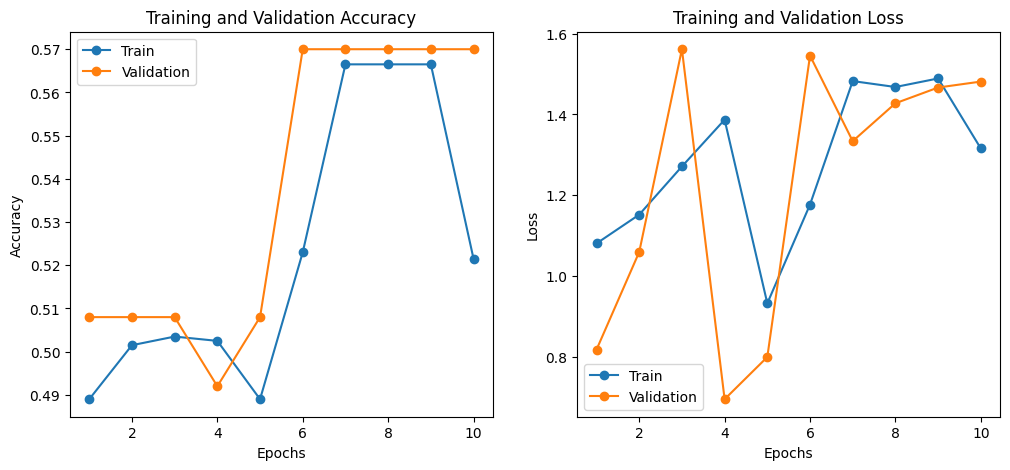

In [26]:
plot_metrics(history)